In [1]:
from geodude.utils import Paper, merge_LineStrings
import vsketch
import numpy as np
from shapely.geometry import (
    box, 
    MultiLineString, 
    Point, 
    MultiPoint, 
    Polygon, 
    MultiPolygon, 
    LineString,
    )

from fn.fn import new_savepath
from geodude.ops import make_like
from shapely import is_valid, unary_union
import itertools
import pandas as pd
import geopandas as gpd
from matplotlib import pyplot as plt
from geodude.line import dash_linestring, bezier_func
from geodude.intersection import (
    pairwise_partition_polygons, 
    polys_to_gdf, 
    find_intersecting_polys,
    find_touching_polys, 
    find_clusters, 
    find_contained_polys, 
    find_parent_polygons,
    merge_disjoint_polys,
    assign_random_order_to_adjacent_clusters,
    assign_psuedoperiodic_order_to_adjacent_clusters,
    chunked_pairwise_partition_polygons
    )
from geodude.ops import buft_fill
from geodude.parameter import Prm, prms

%load_ext autoreload
%autoreload 2

In [2]:

# make page
paper_size = '11x14 inches'
border:float=30
paper = Paper(paper_size)

drawbox = paper.get_drawbox(border)

In [3]:

n_lines = 20
xmin, ymin, xmax, ymax = drawbox.bounds
width = xmax - xmin


des_xmin = xmin + width * 0.2
des_xmax = xmax - width * 0.2
des_xrange = (des_xmin, des_xmax)


init_rel_xs = np.linspace(0, 1, n_lines)



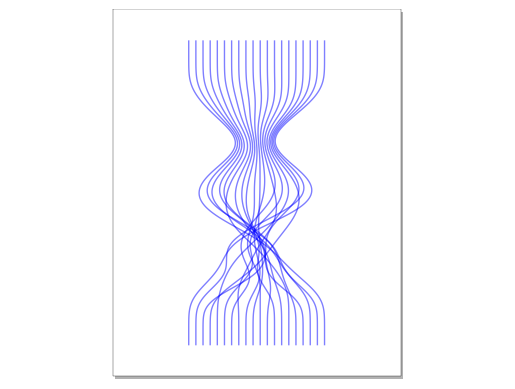

In [4]:
def get_ctrl_pts(x):
    xs = [
        np.interp(x, [0, 1], [0, 1],),
        np.interp(x, [0, 1], [0, 1],),
        np.interp(x, [0, 1], [0, 1],),
        np.interp(x, [0, 1], [0, 1],),
        np.interp(x, [0, 1], [0, 1],),
        np.interp(x, [0, 1], [0, 1],),
        np.interp(x, [0, 1], [0, 1],),
        np.interp(x, [0, 1], [0, 1],),
        np.interp(x, [0, 1], [0, 1],),
        
        np.interp(x, [0, 1], [0, 1],),
        np.interp(x, [0, 1], [0, 1],),
        np.interp(x, [0, 1], [0, 1],),
        
        np.interp(x, [0, 0.8], [0.2, 0.8],),
        np.interp(x, [0, 0.8], [0.2, 0.8],),
        np.interp(x, [0, 0.8], [0.2, 0.8],),
        np.interp(x, [0.2, 1.2], [0.2, 0.8],),
        np.interp(x, [0.2, 1.2], [0.2, 0.8],),
        np.interp(x, [0.2, 1.2], [0.2, 0.8],),
        np.interp(x, [0.3, 1.3],  [0.7, 0.2],),
        np.interp(x, [0.3, 1.3],  [0.7, 0.2],),
        np.interp(x, [0.3, 1.3],  [0.7, 0.2],),
        np.interp(x, [0., 1.2], [0.2, 0.9],),
        np.interp(x, [0., 1.2], [0.2, 0.9],),
        np.interp(x, [0., 1.2], [0.2, 0.9],),
        np.interp(x, [0, 1], [0, 1],),
        np.interp(x, [0, 1], [0, 1],),
        np.interp(x, [0, 1], [0, 1],),
        
        np.interp(x, [0, 1], [0, 1],),
        np.interp(x, [0, 1], [0, 1],),
        np.interp(x, [0, 1], [0, 1],),
        
        np.interp(x, [0, 1], [0, 1],),
        np.interp(x, [0, 1], [0, 1],),
        np.interp(x, [0, 1], [0, 1],),
        
        np.random.uniform(0, 1),
        np.random.uniform(0, 1),
        np.random.uniform(0, 1),
        np.interp(x, [0, 1], [1, 0],),
        np.random.uniform(0, 1),
        np.random.uniform(0, 1),
        np.random.uniform(0, 1),
        np.interp(x, [0, 1], [1, 0],),
        np.random.uniform(0, 1),
        np.random.uniform(0, 1),
        np.random.uniform(0, 1),
        
        np.interp(x, [0, 1], [1, 0],),
        np.interp(x, [0, 1], [1, 0],),
        np.interp(x, [0, 1], [1, 0],),
        np.interp(x, [0, 1], [1, 0],),
        np.interp(x, [0, 1], [1, 0],),
        np.interp(x, [0, 1], [1, 0],),
        np.interp(x, [0, 1], [1, 0],),
        np.interp(x, [0, 1], [1, 0],),
        np.interp(x, [0, 1], [1, 0],),
        np.interp(x, [0, 1], [1, 0],),
        np.interp(x, [0, 1], [1, 0],),
        np.interp(x, [0, 1], [1, 0],),
        
    ]
    xs = np.interp(xs, [0, 1], des_xrange,)
    ys = np.linspace(ymin, ymax, len(xs))
    return list(zip(xs, ys))


ctrl_pt_sets = [get_ctrl_pts(x) for x in init_rel_xs]
bezier_funcs = [bezier_func(ctrl_pts) for ctrl_pts in ctrl_pt_sets]
n_eval_pts = 200
eval_pts = np.linspace(0,1,n_eval_pts)
lines = [bezier_func(eval_pts) for bezier_func in bezier_funcs]

mls = MultiLineString(lines)

sk = vsketch.Vsketch()
sk.size(paper.page_format_mm)
sk.scale('1mm')
sk.penWidth('0.05mm')

sk.geometry(mls)
sk.display()

In [5]:
buffed = [l.buffer(2, cap_style='square') for l in mls.geoms]

In [6]:
gdf = polys_to_gdf(buffed)
disjoint = chunked_pairwise_partition_polygons(
    gdf, 
    chunk_size=10,
    min_area=1e-3,
    )

Iteration 1
Finding intersections in 20 polygons
380 intersections remaining
Chunking polygons
Partitioning 2 chunks


2it [00:00, 23.78it/s]


Iteration 1 complete, 52 polygons remaining
Iteration 2
Finding intersections in 52 polygons
644 intersections remaining
Chunking polygons
Partitioning 6 chunks


6it [00:00, 15.77it/s]


Iteration 2 complete, 127 polygons remaining
Iteration 3
Finding intersections in 127 polygons
924 intersections remaining
Chunking polygons
Partitioning 12 chunks


12it [00:01,  8.14it/s]


Iteration 3 complete, 326 polygons remaining
Iteration 4
Finding intersections in 326 polygons
1160 intersections remaining
Chunking polygons
Partitioning 26 chunks


26it [00:01, 17.03it/s]


Iteration 4 complete, 469 polygons remaining
Iteration 5
Finding intersections in 469 polygons
1052 intersections remaining
Chunking polygons
Partitioning 32 chunks


32it [00:01, 18.69it/s]


Iteration 5 complete, 471 polygons remaining
Iteration 6
Finding intersections in 471 polygons
752 intersections remaining
Chunking polygons
Partitioning 32 chunks


32it [00:01, 24.82it/s]


Iteration 6 complete, 360 polygons remaining
Iteration 7
Finding intersections in 360 polygons
448 intersections remaining
Chunking polygons
Partitioning 23 chunks


23it [00:00, 35.36it/s]


Iteration 7 complete, 244 polygons remaining
Iteration 8
Finding intersections in 244 polygons
288 intersections remaining
Chunking polygons
Partitioning 16 chunks


16it [00:00, 38.03it/s]


Iteration 8 complete, 170 polygons remaining
Iteration 9
Finding intersections in 170 polygons
200 intersections remaining
Chunking polygons
Partitioning 11 chunks


11it [00:00, 44.51it/s]


Iteration 9 complete, 116 polygons remaining
Iteration 10
Finding intersections in 116 polygons
160 intersections remaining
Chunking polygons
Partitioning 9 chunks


9it [00:00, 47.55it/s]


Iteration 10 complete, 91 polygons remaining
Iteration 11
Finding intersections in 91 polygons
128 intersections remaining
Chunking polygons
Partitioning 8 chunks


8it [00:00, 23.14it/s]


Iteration 11 complete, 98 polygons remaining
Iteration 12
Finding intersections in 98 polygons
58 intersections remaining
Chunking polygons
Partitioning 4 chunks


4it [00:00, 27.84it/s]


Iteration 12 complete, 38 polygons remaining
Iteration 13
Finding intersections in 38 polygons
28 intersections remaining
Chunking polygons
Partitioning 2 chunks


2it [00:00, 14.68it/s]

Iteration 13 complete, 17 polygons remaining
Iteration 14
Finding intersections in 17 polygons
0 intersections remaining
Chunking polygons


In [7]:

disjoint = find_parent_polygons(disjoint=disjoint, original=gdf)

disjoint = assign_random_order_to_adjacent_clusters(disjoint)


In [8]:

ngdf = merge_disjoint_polys(disjoint)
ngdf = ngdf.explode(index_parts=False).reset_index(drop=True)

# clean up with closing + opening
buffer_value = 0.01
ngdf.geometry = ngdf.buffer(buffer_value).buffer(-buffer_value)
ngdf.geometry = ngdf.buffer(-buffer_value).buffer(buffer_value)
ngdf = ngdf.explode(index_parts=False).reset_index(drop=True)


In [9]:

ngdf['area'] = ngdf.area
idx = (ngdf.area > 1e-6) & ~ngdf.is_empty & (ngdf.geom_type == 'Polygon')
# idx = idx & ngdf.is_valid
ngdf = ngdf[idx]

lss = [p.boundary for p in ngdf.geometry if p.boundary is not None]
mls = merge_LineStrings(lss)



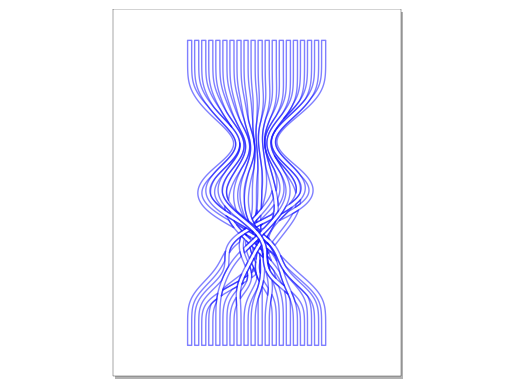

In [10]:
sk = vsketch.Vsketch()
sk.scale('1mm')
sk.penWidth('0.05mm')
sk.size(paper.page_format_mm)
sk.geometry(make_like(mls, drawbox))
sk.display()


In [74]:
sk.vpype('splitall linemerge linesort')

In [75]:
fp = new_savepath(postfix='weave')
sk.save(fp)

In [11]:
fills = []
for geom in gdf.geometry:
    d_buffer = Prm(-0.3)
    d_translate = Prm(lambda : d_buffer() * 0.9)
    deg = Prm(np.random.uniform(45, 90))
    polys = buft_fill(
        geom=geom, 
        d_translate=d_translate, 
        d_buffer=d_buffer, 
        deg=deg, 
        n_iters=100)
    fills.append(polys.boundary)

In [12]:
fill_gdf = polys_to_gdf(fills)

In [14]:
masked = []

for ii, row in fill_gdf.iterrows():
    fill = row.geometry
    mask = ngdf.query('parent == @ii').geometry.buffer(1e-6)
    masked.append(fill.intersection(mask))

In [22]:
masked = pd.concat(masked)

In [23]:
masked = masked[~masked.is_empty]

In [24]:
fill_mls = merge_LineStrings(masked.to_list())

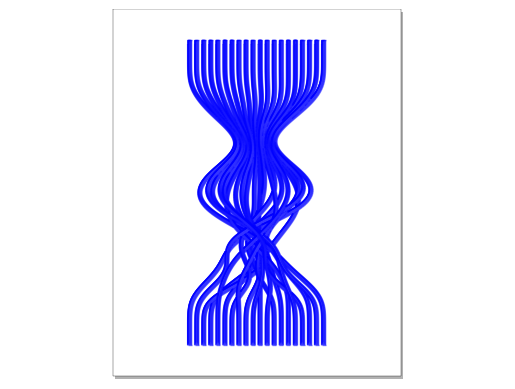

In [25]:
sk = vsketch.Vsketch()
sk.scale('1mm')
sk.penWidth('0.05mm')
sk.size(paper.page_format_mm)
sk.geometry(make_like(fill_mls, drawbox))
sk.display()

In [26]:
sk.vpype('splitall linemerge linesort')

In [27]:
fp = new_savepath(postfix='filled_weave')
sk.save(fp)